In [53]:
import cdsapi
import os

folder_out = r''

############################## Basic Settings ############################ 
cut_below_kW = 3 # improve by cutting out the low power values below a threshold & below 3 m/s
do_cleaning = True
match_summer = False
cut_off_factor = 1.5 # remove values which are more max/cut_off_factor times away from the windpowerlib power curve -> larger factor = more values removed
time_shift = 0 # artificial time shift for testing in minutes
add_bias_factor = 0 # add a bias to the wind speed in percent -> cmr: still testing: make automatic adaption of reanalysis power? 
year = 2022

# # # ########################### Ü20_600 ############################
# location = 'Ü20_600' 
# lat = 50.667236 
# lon = 12.348829 
# hubheight = 63
# rotor_diameter = 48
# turb_type = 'E48/800' # if there is no type, use the scale_turbine_to parameter to scale the turbine to a specific power
# max_power = 600
# scale_turbine_to = 550
# excel_input = 'DÜ20_600_kw_2022-01-01_2022-12-31.xlsx' # TODO: get test data


point = str(lat) + '/' + str(lon) + '/' + str(lat) + '/' + str(lon)

# create a client object
c = cdsapi.Client()
year_s = [str(year)]
# define the request parameters
months = [str(i).zfill(2) for i in range(1, 13)] #max 6 months
days = [str(i).zfill(2) for i in range(1, 32)]
variables_list = ['2m_temperature',
                '10m_u_component_of_wind', 
                '10m_v_component_of_wind',
                '100m_u_component_of_wind', 
                '100m_v_component_of_wind',
                'forecast_surface_roughness',
                'surface_pressure']

# define the output file name by year day and month 
downloaded_file = location+'_ERA5-Reanalysis_' + year_s[0] + months[0] + days[0] +'_till_' + year_s[0] + months[-1] + days[-1] + '_winds.nc'
downloaded_file = os.path.join(folder_out, downloaded_file)

# check if the file already exists
if os.path.isfile(downloaded_file) == False:
    # send the request to the CDS server
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'year': year_s[0],
            'month': months,
            'day': days,
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',],
            'variable': variables_list,
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'area': point, # extract data for a single point
            #'LEVELIST': '10/25/50/75/100', # specify the desired levels in meters
        },
        downloaded_file
    )

In [54]:
import plotly.graph_objects as go
import xarray as xr
import netCDF4 as nc
import numpy as np
import datetime
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# read the downloaded file
data = nc.Dataset(downloaded_file, 'r')

# extract the u and v wind components
time = data.variables['time'][:]
t2m = data.variables['t2m'][:]
u10 = data.variables['u10'][:] 
v10 = data.variables['v10'][:] 
u100 = data.variables['u100'][:] 
v100 = data.variables['v100'][:] 
fsr = data.variables['fsr'][:]
sp = data.variables['sp'][:]

# close the file
data.close()

# convert time to list of datetime objects
dates = []
for t in time:
    date = datetime.datetime(1900, 1, 1) + datetime.timedelta(hours=int(t)-1) # hours=int(t)-1 as data is in UTC
    dates.append(date)

# get absolute wind speed
wind_speed_10m = (u10**2 + v10**2)**0.5
wind_speed_100m = (u100**2 + v100**2)**0.5

# Calculate wind speed at 100m using power law
height = 100.0
h = height - 10.0
alpha = 0.143  # typical value for neutral conditions
wind_speed_100m_p_law = wind_speed_10m * (h / 10.0) ** alpha


# create a dictionary with the variables
data_dict = {'wind_speed_10m': wind_speed_10m.flatten(), 
             'wind_speed_100m': wind_speed_100m.flatten(),
             'fsr': fsr.flatten(),
             't2m': t2m.flatten(),
             'sp': sp.flatten()
             }
             #'wind_speed_100m_p_law': wind_speed_100m_p_law.flatten(),
             #

# create a pandas DataFrame with the dictionary
df_weather = pd.DataFrame(data_dict, index=dates)
# create the MultiIndex columns
col_dict = {('wind_speed', 10): ('wind_speed_10m', 'wind_speed'),
            ('wind_speed', 100): ('wind_speed_100m', 'wind_speed'),
            ('roughness_length', 0): ('fsr', 'roughness_length'),
            ('temperature', 2): ('t2m', '2mtemperature'),
            ('pressure', 0): ('sp', 'pressure')}
df_weather.columns = pd.MultiIndex.from_tuples(col_dict.keys(), names=['variable_name', 'height'])
df_weather = df_weather.rename(columns=col_dict)

df_weather.index = pd.to_datetime(df_weather.index).tz_localize('UTC').tz_convert('Europe/Berlin')
# remove last values of the year as ERA5 starts at 1 hour later
# cmr_time next_year = str(year + 1)
# cmr_time df_weather = df_weather[df_weather.index < next_year+'-01-01']

df_weather

variable_name             wind_speed            roughness_length temperature  \
height                           10         100              0           2     
2022-01-01 00:00:00+01:00   5.223295   9.090541         0.791208  284.945660   
2022-01-01 01:00:00+01:00   4.904007   8.680536         0.791259  284.824762   
2022-01-01 02:00:00+01:00   4.446014   8.067712         0.791266  284.790991   
2022-01-01 03:00:00+01:00   4.436181   8.205715         0.791220  284.815981   
2022-01-01 04:00:00+01:00   4.737730   8.536514         0.791252  284.873391   
...                              ...        ...              ...         ...   
2022-12-31 19:00:00+01:00   7.972986  13.399050         0.792118  287.660813   
2022-12-31 20:00:00+01:00   8.315042  13.797520         0.792823  287.941109   
2022-12-31 21:00:00+01:00   8.520572  14.056837         0.793317  288.365942   
2022-12-31 22:00:00+01:00   9.138641  14.911370         0.793611  288.495621   
2022-12-31 23:00:00+01:00   8.922913  14.519672         0.793706  288.804284   

variable_name                   pressure  
height                               0    
2022-01-01 00:00:00+01:00  101729.629444  
2022-01-01 01:00:00+01:00  101770.683534  
2022-01-01 02:00:00+01:00  101823.497364  
2022-01-01 03:00:00+01:00  101828.747248  
2022-01-01 04:00:00+01:00  101893.005823  
...                                  ...  
2022-12-31 19:00:00+01:00  100247.272298  
2022-12-31 20:00:00+01:00  100265.226900  
2022-12-31 21:00:00+01:00  100270.476784  
2022-12-31 22:00:00+01:00  100275.411674  
2022-12-31 23:00:00+01:00  100335.050352  

[8760 rows x 5 columns]

In [55]:
from windpowerlib import ModelChain, WindTurbine, create_power_curve
from windpowerlib import data as wt
import logging
logging.getLogger().setLevel(logging.DEBUG)


In [56]:
################# get names of wind turbines for which power curves and/or are provided #################

# print_out=True # to see the list of all available wind turbines
# df_turbines = wt.get_turbine_types(print_out=False)
# df_turbines
# # find special types of turbines
# print(df_turbines[df_turbines["manufacturer"].str.contains("Siemens")])

In [57]:
# specification of wind turbine where power curve is provided in the 
# oedb turbine library

windpowerlib_turbine = {
        "nominal_power": max_power*1000,  # in W
        'turbine_type': turb_type,  # turbine type as in oedb turbine library
        'hub_height': hubheight,  # in m
        #'rotor_diameter' : rotor_diameter # in m
    }
# initialize WindTurbine object
wpl_turbine = WindTurbine(**windpowerlib_turbine)

#create_power_curve(wind_speed=x_values, power=y_values*1000
  #  )
#scale_turbine_to = None
# to the given value
if scale_turbine_to is not None:
    wpl_turbine.power_curve['value'] =  wpl_turbine.power_curve['value']* scale_turbine_to*1000/max(wpl_turbine.power_curve['value'])
    

In [58]:
df_power_hist = pd.read_excel(excel_input)
df_power_hist = df_power_hist.drop(index=range(6))
df_power_hist = df_power_hist.drop(df_power_hist.columns[1], axis=1)
df_power_hist = df_power_hist.rename(columns={df_power_hist.columns[0]: 'datetime',df_power_hist.columns[1]: 'real_power',df_power_hist.columns[2]: 'real_power_2'})

# convert datetime to UTC timezone aware datetime
df_power_hist['datetime'] = pd.to_datetime(df_power_hist['datetime'], utc=True)
# add time shift in minutes
df_power_hist['datetime'] = df_power_hist['datetime'] + datetime.timedelta(minutes=time_shift) 
#cmr: make time shift as below, here it is not working
#df_power_and_wind_shifted['time_shifted'] = df_power_and_wind_shifted.index - pd.Timedelta(minutes=delta)
#df_power_and_wind_shifted.set_index('time_shifted', inplace=True)

# convert to the desired timezone
df_power_hist['datetime'] = df_power_hist['datetime'].dt.tz_convert('Europe/Berlin')


In [59]:

# copy df_power_hist into two seperaste dfs
df_real_power_2 = df_power_hist.copy()
# and delete the real_power column
df_real_power_2 = df_real_power_2.drop('real_power', axis=1)
# in df power_hist delete the real_power_2 column
df_power_hist = df_power_hist.drop('real_power_2', axis=1)

# Group by hour and calculate mean of the four 15-minute values, seperately for each column
df_power_hist_hourly = df_power_hist.groupby(pd.Grouper(key='datetime', freq='1H')).mean()

# remove the first row, as
# cmr_time df_power_hist_hourly = df_power_hist_hourly.iloc[1:]

# copy df_power_hist_hourly into two seperaste dfs
df_power_hist_hourly_all = df_power_hist_hourly.copy()
df_power_hist_hourly

real_power
datetime                             
2022-01-01 00:00:00+01:00      2317.5
2022-01-01 01:00:00+01:00      2023.5
2022-01-01 02:00:00+01:00      1989.0
2022-01-01 03:00:00+01:00      1449.0
2022-01-01 04:00:00+01:00       406.5
...                               ...
2022-12-31 19:00:00+01:00         3.0
2022-12-31 20:00:00+01:00         4.5
2022-12-31 21:00:00+01:00         6.0
2022-12-31 22:00:00+01:00         1.5
2022-12-31 23:00:00+01:00         1.5

[8760 rows x 1 columns]

C:\Users\MatthiasReif\AppData\Local\Temp\ipykernel_13624\1072040459.py:2: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)

C:\Users\MatthiasReif\AppData\Local\Temp\ipykernel_13624\1072040459.py:24: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)

c:\Users\MatthiasReif\miniconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

overflow encountered in exp

c:\Users\MatthiasReif\miniconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated

C:\Users\MatthiasReif\AppData\Local\Temp\ipykernel_13624\1072040459.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

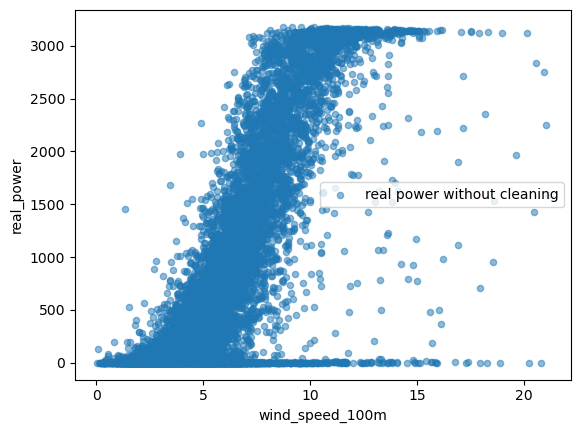

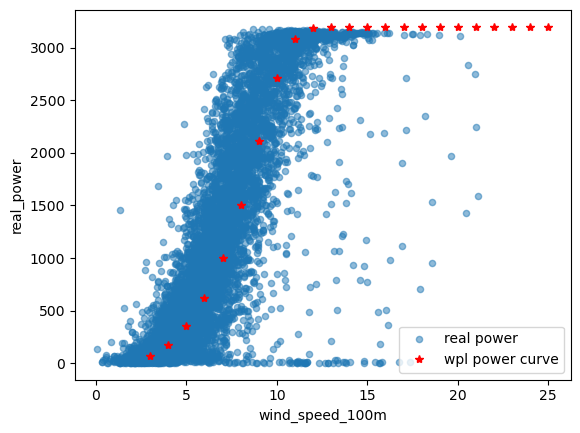

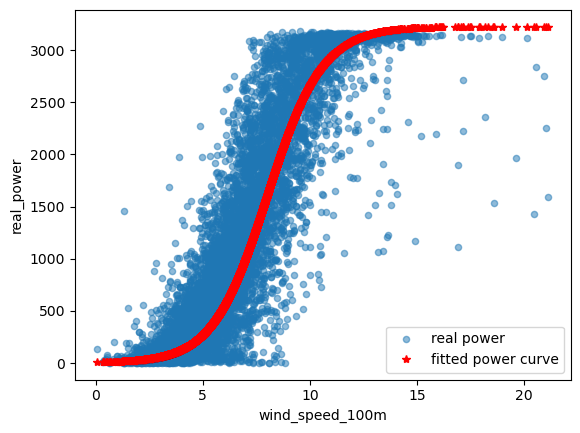

In [60]:

# merge dataframes based on the datetime index
df_power_and_wind_hourly_all = df_power_hist_hourly_all.merge(df_weather[('wind_speed',100)], left_index=True, right_index=True)
# rename columns for clarity
df_power_and_wind_hourly_all = df_power_and_wind_hourly_all.rename(columns={('real_power', ''): 'real_power', ('wind_speed', 100): 'wind_speed_100m'})
# plot the data against each other on a scatter plot withuot the cleaning
plt = df_power_and_wind_hourly_all.plot.scatter(x='wind_speed_100m', y='real_power', alpha=0.5)
plt.legend(['real power without cleaning'])

# set all values below x kW to NaN  
df_power_hist_hourly.loc[df_power_hist_hourly['real_power'] < cut_below_kW , 'real_power'] = np.nan
# adding bias for testing
df_power_hist_hourly['real_power'] = df_power_hist_hourly['real_power'] + df_power_hist_hourly['real_power'] * add_bias_factor/100

# same for the second time series in excel input: real_power_2
df_real_power_2_hourly = df_real_power_2.groupby(pd.Grouper(key='datetime', freq='1H')).mean()
df_real_power_2_hourly['real_power_2'] = df_real_power_2_hourly['real_power_2']*1000 #convert to W
# remove the first row, as ERA5 data starts at 1:00
# cmr_time df_real_power_2_hourly = df_real_power_2_hourly.iloc[1:]

# print(df_power_hist_hourly)
# print(df_real_power_2_hourly)

# merge dataframes based on the datetime index
df_power_and_wind = df_power_hist_hourly.merge(df_weather[('wind_speed',100)], left_index=True, right_index=True)
# rename columns for clarity
df_power_and_wind = df_power_and_wind.rename(columns={('real_power', ''): 'real_power', ('wind_speed', 100): 'wind_speed_100m'})
# find real_power values that are smaller than x W and set them to NaN
#df_power_and_wind.loc[df_power_and_wind['real_power'] < cut_below_kW, 'real_power'] = np.nan
# remove rows with NaN values
df_power_and_wind = df_power_and_wind.dropna()

# plot the merged data against each other on a scatter plot
plt = df_power_and_wind.plot.scatter(x='wind_speed_100m', y='real_power', alpha=0.5)
# add wpl_turbine.power_curve to the plot
plt.plot(wpl_turbine.power_curve['wind_speed'], wpl_turbine.power_curve['value']/1000, color='red',marker='*', linestyle='None')
#add legend
plt.legend(['real power', 'wpl power curve'])

############### filter for outliers ################
# is cleaning data in the vertical direction 
# need to define a threshold to give a warning, that the data is not clean
if do_cleaning == True:
    # Define the logistic function
    def logistic(x, a, b, c):
        return c / (1 + np.exp(-a*(x-b)))

    maxfev_x=10000 #maximum number of function evaluations
    # fit logistic function to wpl_turbine.power_curve
    popt, pcov = curve_fit(logistic, wpl_turbine.power_curve['wind_speed'], wpl_turbine.power_curve['value']/max(wpl_turbine.power_curve['value']), maxfev=maxfev_x)
    # Predict power output using the logistic function
    df_power_and_wind['predicted_power'] = logistic(df_power_and_wind['wind_speed_100m'], *popt) * max(wpl_turbine.power_curve['value'])/1000
    #cmr add df_power_and_wind['predicted_wind'] from power curve to calculate residuals of wind(power)
    popt_inv, pcov_inv = curve_fit(logistic, wpl_turbine.power_curve['value']/max(wpl_turbine.power_curve['value']),wpl_turbine.power_curve['wind_speed'],maxfev=maxfev_x)
    df_power_and_wind['predicted_wind'] = logistic(df_power_and_wind['real_power'], *popt_inv)

    #print(df_power_and_wind['predicted_wind'])
    # Calculate the power_residual errors between the predicted and actual power output
    df_power_and_wind['power_residual'] = df_power_and_wind['real_power'] - df_power_and_wind['predicted_power']

    
    # Remove data points with high power_residual errors
    df_filtered = df_power_and_wind[abs(df_power_and_wind['power_residual']) < max(df_power_and_wind['real_power'])/cut_off_factor]
    # new column in df_power_and_wind['filtered'] to mark filtered data points with False, the rest with True
    df_power_and_wind['filtered'] = False
    # set all values in df_power_and_wind['filtered'] to True if the index is in df_filtered
    df_power_and_wind.loc[df_power_and_wind.index.isin(df_filtered.index), 'filtered'] = True
    # set all values in df_power_and_wind['real_power'] to NaN if 'filtered' is False
    df_power_and_wind.loc[df_power_and_wind['filtered'] == False, 'real_power'] = np.nan
    # overwrite df_power_hist_hourly with df_power_and_wind and set NaN if 'filtered' is True
    df_power_hist_hourly['real_power'] = df_power_and_wind['real_power'] 

    # set real_power to NaN where it is below the threshold and wind_speed_100m is above 3 m/s
    df_filtered.loc[(df_filtered['real_power'] < cut_below_kW) & (df_power_and_wind['wind_speed_100m'] > 3), 'real_power'] = np.nan



    # Plot the filtered data
    plt = df_filtered.plot.scatter(x='wind_speed_100m', y='real_power', alpha=0.5)
    plt.plot(df_power_and_wind['wind_speed_100m'], df_power_and_wind['predicted_power'], color='red',marker='*', linestyle='None')
    plt.legend(['real power', 'fitted power curve'])


In [61]:
# # # another try to clean the data and find a threshold

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# # remove rows with NaN values
# df = df_power_and_wind

# # define bin size for grouping real_power values
# bin_size = 10

# # create new column for power groups based on bin size
# df['power_group'] = np.floor(df['real_power'] / bin_size) * bin_size

# # iterate over power groups and remove outliers based on weighted z-score threshold
# for group in df['power_group'].unique():
#     group_df = df.loc[df['power_group'] == group]
#     if len(group_df) < 3:  # skip groups with less than 3 values
#         continue
#     z_scores = stats.zscore(group_df['real_power'])
#     weighted_z_scores = (2 * z_scores[1:-1] + z_scores[:-2] + z_scores[2:]) / 4  # calculate weighted z-scores
#     abs_weighted_z_scores = np.abs(weighted_z_scores)
#     filtered_entries = (abs_weighted_z_scores < 3)
#     df.loc[(df['power_group'] == group) & (df.index.isin(group_df[1:-1][filtered_entries].index)), 'real_power'] = group_df[1:-1][filtered_entries]['real_power']

# # plot the cleaned data on a scatter plot
# plt.scatter(df['wind_speed_100m'], df['real_power'], alpha=0.5)
# plt.title('Wind turbine power vs wind speed at 100m')
# plt.xlabel('Wind speed at 100m (m/s)')
# plt.ylabel('Wind turbine power (kW)')
# plt.show()


In [62]:
# # also trying to filter outliers

# # Group the data by wind speed in 1 m/s steps and calculate the mean power
# df_grouped = df_power_and_wind.groupby(pd.cut(df_power_and_wind['wind_speed_100m'], np.arange(3, 30,0.2))).mean()
# # Plot the power curve
# plt = df_grouped.plot.scatter(x='wind_speed_100m', y='real_power', alpha=0.5)

# df_power_and_wind = df_grouped.dropna() # use the grouped data for the power curve


In [63]:


# define the logistic function
def logistic_function(x, a, b, c, d):
    return a / (1 + np.exp(-b * (x - c))) + d

# fit the logistic function to the data
if do_cleaning == True:
    p0 = [max(df_filtered['real_power']), 1, np.median(df_filtered['wind_speed_100m']), min(df_filtered['real_power'])] # initial guess for parameters
    popt, pcov = curve_fit(logistic_function, df_filtered['wind_speed_100m'], df_filtered['real_power'], p0)
else:
    p0 = [max(df_power_and_wind['real_power']), 1, np.median(df_power_and_wind['wind_speed_100m']), min(df_power_and_wind['real_power'])] # initial guess for parameters
    popt, pcov = curve_fit(logistic_function, df_power_and_wind['wind_speed_100m'], df_power_and_wind['real_power'], p0)

# generate 20 x values between the minimum and maximum wind speeds
wind_max_extension = 3
x_values = np.linspace(df_power_and_wind['wind_speed_100m'].min(), df_power_and_wind['wind_speed_100m'].max()+wind_max_extension, num=20)

# use the logistic function to generate 20 y values
y_values = logistic_function(x_values, *popt)

# # modify y values to cut off below cut_below_kW and set max value for wind speeds above 30
for i in range(len(y_values)):
    if y_values[i] < cut_below_kW:
        y_values[i] = 0
    elif y_values[i] > max(df_power_and_wind['real_power']):
        y_values[i] = max(df_power_and_wind['real_power'])

# # calculate the step size in x_values
# step_size = x_values[1] - x_values[0]
# # append 10 more x_values and set y_values to max(df_power_and_wind['real_power']) at the end of the lists
# for i in range(10):
#     x_values = np.append(x_values, x_values[-1]+step_size)
#     y_values = np.append(y_values, max(df_power_and_wind['real_power']))
# from scipy.signal import savgol_filter
# #smooth the power curve in the 5 steps before and after appending the 10 x_values
# y_values[-15:] = savgol_filter(y_values[-15:], window_length=8, polyorder=1)

# # print the value pairs
# for x, y in zip(x_values, y_values):
#     print(f"({x:.2f}, {y:.2f})")


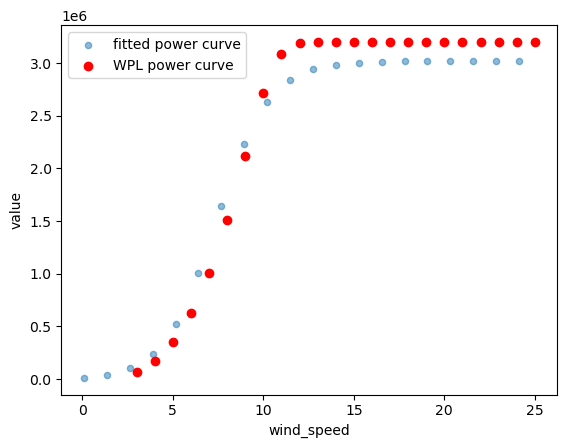

In [64]:
# specification of wind turbine where power coefficient curve and nominal
# power is provided in an own csv file

# Read your turbine data from your data file using functions like
# pandas.read_csv().
# >>> import pandas as pd
# >>> my_data = pd.read_csv("path/to/my/data/file")
# >>> real_power = my_data["real_power"]
# >>> my_wind_speed = my_data["my_wind_speed"]

#real_power = pd.Series([0.0, 39000.0, 270000.0, 2250000.0, 4500000.0, 4500000.0])
#my_wind_speed = (0.0, 3.0, 5.0, 10.0, 15.0, 25.0)

# def smooth_power_curve(
#     power_curve_wind_speeds,
#     power_curve_values,
#     block_width=0.5,
#     wind_speed_range=15.0,
#     standard_deviation_method="turbulence_intensity",
#     mean_gauss=0,

my_turbine = {
    "nominal_power": max_power*1000,  # in W
    "hub_height": hubheight,  # in m
    "power_curve": create_power_curve(
        wind_speed=x_values, power=y_values*1000
    ),
}

my_turbine = WindTurbine(**my_turbine)

#my_turbine.power_curve.plot(x='wind_speed', y='value', style='*',
#                    title='Calibrated power curve')
# add wpl_turbine.power_curve to the plot
#plt.plot(wpl_turbine.power_curve['wind_speed'], wpl_turbine.power_curve['value'], 'r')
plt = my_turbine.power_curve.plot.scatter(x='wind_speed', y='value', alpha=0.5)

# add wpl_turbine.power_curve to the plot
plt.scatter(wpl_turbine.power_curve['wind_speed'], wpl_turbine.power_curve['value'], color='red')
# add legend for the two curves
plt.legend(['fitted power curve', 'WPL power curve'])


In [65]:

# own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'barometric',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model':
        'power_curve',                      # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
    'density_correction': False,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None

# initialize ModelChain with own specifications and use run_model method to
# calculate power output
mc_wpl_turbine = ModelChain(wpl_turbine, **modelchain_data).run_model(
    df_weather)
# write power output time series to WindTurbine object
wpl_turbine.power_output = mc_wpl_turbine.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [66]:
# power output calculation for my_turbine

# initialize ModelChain with default parameters and use run_model
# method to calculate power output
mc_my_turbine = ModelChain(my_turbine).run_model(df_weather)
# write power output time series to WindTurbine object
my_turbine.power_output = mc_my_turbine.power_output


DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [67]:
# # windspeed model hellman

# # power output calculation for example_turbine
# # own specification for 'power_output_model'
# my_turbine_hellman = my_turbine
# mc_hellman_turbine = ModelChain(my_turbine_hellman,wind_speed_model='hellman').run_model(df_weather)
# my_turbine_hellman.power_output = mc_hellman_turbine.power_output

In [68]:

# convert wpl_turbine.power_output.values to valid DatetimeIndex
df_out = pd.DataFrame(wpl_turbine.power_output.values/1000, index=wpl_turbine.power_output.index, columns=["WPL Power"])
# add my_turbine power output to the dataframe
df_out['Calibrated Power'] = my_turbine.power_output.values/1000
#expand the timeseries to 15 min resolution, with 4 times the hourly value  
#df_out = df_out.resample('15min').ffill()

# remove timezone information from index
df_out.index = df_out.index.tz_localize(None)
#format index as date for excel     
df_out.index = df_out.index.strftime('%d.%m.%Y %H:%M:%S')

df_out.to_excel(location+'_power_from_reanalysis.xlsx')

#df_out

In [69]:
# Create a scatter plot of wind speed at 10m and 100m and power output in a second y-axis
import plotly.graph_objects as go
from plotly import subplots
from plotly.offline import plot

# use plotly.tools.make_subplots to create the figure with a subplot grid
fig = subplots.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.001,specs=[[{"secondary_y": True}],[{"secondary_y": True}],[{"secondary_y": True}]])

#fig = go.Figure()
# add first trace to first axis
fig.add_trace(go.Scatter(x=df_weather.index, y=df_weather[('wind_speed',100)], name='Wind 100m'), secondary_y=True, row=1, col=1)
# add second trace to first axis
fig.add_trace(go.Scatter(x=df_weather.index, y=df_power_hist_hourly_all['real_power']*1000, name='real power output'), row=1, col=1)
# set first axis title
fig.update_yaxes(title_text='wind Speed (m/s)', secondary_y=True, row=1, col=1)
# set second axis title
fig.update_yaxes(title_text='power (kW)', secondary_y=False)
# Set the plot title and axes labels
fig.update_layout(title=location+' real power, reanalysis and backcast ')

fig.add_trace(go.Scatter(x=df_weather.index, y=df_power_hist_hourly['real_power']*1000, name='real power output cleaned'), row=2, col=1)
# add second trace to first axis
fig.add_trace(go.Scatter(x=df_weather.index, y=df_real_power_2_hourly['real_power_2'], name='enercast backcast'),  row=2, col=1)
# add third trace to second axis with my_turbine power output
fig.add_trace(go.Scatter(x=df_weather.index, y=wpl_turbine.power_output, name='reanalysis with turbine powercurve'), row=2, col=1)
# plot also my_turbine.power_output in a third axis
fig.add_trace(go.Scatter(x=df_weather.index, y=my_turbine.power_output, name='reanalysis with tuned powercurve'), secondary_y=True, row=2, col=1)

# set first axis title
fig.update_yaxes(title_text='power delta (kW)', secondary_y=False, row=3, col=1)
# plot a fourth subplot with the difference of hist and my_turbine power output
fig.add_trace(go.Scatter(x=df_weather.index, y=df_real_power_2_hourly['real_power_2']-df_power_hist_hourly['real_power']*1000, name='enercast-real'), row=3, col=1)
# and the same for my_turbine power output
fig.add_trace(go.Scatter(x=df_weather.index, y=wpl_turbine.power_output-df_power_hist_hourly['real_power']*1000, name='turbine-real'), row=3, col=1)
# and the same for my_turbine power output
fig.add_trace(go.Scatter(x=df_weather.index, y=my_turbine.power_output-df_power_hist_hourly['real_power']*1000, name='tuned-real'), row=3, col=1)

# Display the plot
fig.show()

plot(fig, filename="wind_power_reanalysis_"+str(year)+"_"+location+".html")


'wind_power_reanalysis_2022_Schoenemoor_WEA_7.html'

Text(0.5, 0.98, 'Scada 2 and Reanalysis vs. Scada 1')

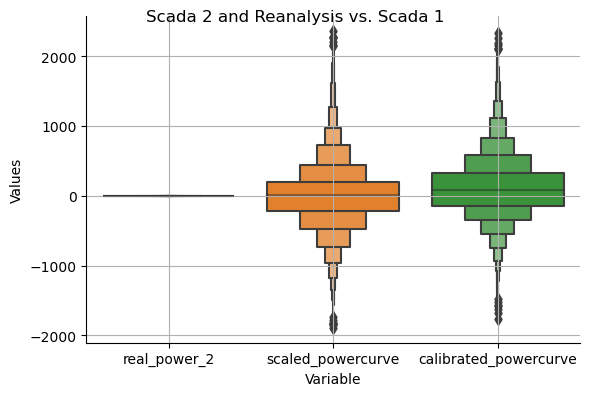

In [70]:
# make plot also for diff with all values


df_diff = pd.DataFrame(df_real_power_2_hourly['real_power_2']/1000-df_power_hist_hourly['real_power'])
# name it 'real_power_2'
df_diff.columns = ['real_power_2']
# add another column with: wpl_turbine.power_output.values-df_power_hist_hourly['real_power']*1000
df_diff['scaled_powercurve'] = wpl_turbine.power_output.values/1000-df_power_hist_hourly['real_power']
# add my_turbine_hellman.power_output in another boxen plot
df_diff['calibrated_powercurve'] = my_turbine.power_output/1000-df_power_hist_hourly['real_power']

# Melt the DataFrame to convert it to long format
df_diff_melted = pd.melt(df_diff, var_name='Variable', value_name='Value')

# Create the boxen plot with both variables
g = sns.catplot(x='Variable', y='Value', data=df_diff_melted, kind='boxen', height=4, aspect=1.5)

# Set the labels for the y-axis and x-axis
g.set_ylabels('Values')
# plot grid IN THE BACKGROUND
g.ax.grid(True)


# Set the title for the plot
g.fig.suptitle('Scada 2 and Reanalysis vs. Scada 1')


In [71]:
import numpy as np
from tabulate import tabulate
from sklearn.metrics import r2_score # ,mean_squared_error, mean_absolute_error

def nrmse(y_true, y_pred):
    """
    Normalized Root Mean Squared Error (NRMSE).
    """
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    range_y = np.max(y_true) - np.min(y_true)
    return rmse / range_y

def nmae(y_true, y_pred):
    """
    Normalized Mean Absolute Error (NMAE).
    """
    mae = np.mean(np.abs(y_true - y_pred))
    range_y = np.max(y_true) - np.min(y_true)
    return mae / range_y

y_true = df_power_hist_hourly['real_power']
y_true_a = df_power_hist_hourly_all['real_power']
y_pred1 = wpl_turbine.power_output.values / 1000
y_pred2 = my_turbine.power_output / 1000
y_pred3 = df_real_power_2_hourly['real_power_2'].values / 1000

nrmse1 = nrmse(y_true, y_pred1)
nrmse2 = nrmse(y_true, y_pred2)
nrmse3 = nrmse(y_true, y_pred3)

nmae1 = nmae(y_true, y_pred1)
nmae2 = nmae(y_true, y_pred2)
nmae3 = nmae(y_true, y_pred3)

nrmse1a = nrmse(y_true_a, y_pred1)
nrmse2a = nrmse(y_true_a, y_pred2)
nrmse3a = nrmse(y_true_a, y_pred3)

nmae1a = nmae(y_true_a, y_pred1)
nmae2a = nmae(y_true_a, y_pred2)
nmae3a = nmae(y_true_a, y_pred3)

# calculate correlation coefficient
# cmr: compare r2score and corr**2
#r2_real_power_2 = r2_score(df_power_hist_hourly['real_power'],df_real_power_2_hourly['real_power_2']) # r2 = corr**2
#r2_real_power_2 = r2_score(df_power_hist_hourly_all['real_power'],df_real_power_2_hourly['real_power_2']) 
r2_real_power_2 = (df_power_hist_hourly['real_power'].corr(df_real_power_2_hourly['real_power_2']))**2 # corr can handle NaN values
r2_real_power_2_a = (df_power_hist_hourly_all['real_power'].corr(df_real_power_2_hourly['real_power_2']))**2

# calculate correlation coefficient for my_turbine
r2_wpl = (df_power_hist_hourly['real_power'].corr(wpl_turbine.power_output))**2
r2_wpl_a = (df_power_hist_hourly_all['real_power'].corr(wpl_turbine.power_output))**2
# calculate correlation coefficient for my_turbine tuned    
r2_tuned = (df_power_hist_hourly['real_power'].corr(my_turbine.power_output))**2
r2_tuned_a = (df_power_hist_hourly_all['real_power'].corr(my_turbine.power_output))**2

headers = ["Model", "nRMSE all", "nMAE all", "R^2" , " ", "nRMSE new", "nMAE new" , "R^2 new"]
table = [
    ["SCADA 2", nrmse3a, nmae3a,r2_real_power_2_a," corrected values ->", nrmse3, nmae3,r2_real_power_2 ],
    ["Reanalysis calibrated", nrmse2a, nmae2a,r2_wpl_a,"", nrmse2, nmae2,r2_wpl],
    ["Reanalysis MPL scaled", nrmse1a, nmae1a,r2_tuned_a,"", nrmse1, nmae1,r2_tuned] 
]

print(tabulate(table, headers=headers))

#count number of values in df_weather[('wind_speed',100)
cleaned_percentage = round((1-df_power_hist_hourly['real_power'].count()/df_weather[('wind_speed',100)].count())*100,1)
print(f"\n {cleaned_percentage} % of the data was cleaned.")



Model                    nRMSE all    nMAE all       R^2                         nRMSE new    nMAE new    R^2 new
---------------------  -----------  ----------  --------  -------------------  -----------  ----------  ---------
SCADA 2                   0           0         1         corrected values ->     0           0          1
Reanalysis calibrated     0.199587    0.128952  0.665701                          0.14999     0.107928   0.787351
Reanalysis MPL scaled     0.197846    0.119138  0.671029                          0.151226    0.103316   0.789888

 19.1 % of the data was cleaned.


In [72]:
# e48.power_coefficient_curve.plot(
# x='wind_speed', y='value', style='*',
# title='Enercon e48 power coefficient curve')
# plt.xlabel('Wind speed in m/s')
# plt.ylabel('Power in W')
# plt.show()
# e48.power_curve.plot(x='wind_speed', y='value', style='*',
#                     title='Enercon e48 power curve')
# plt.xlabel('Wind speed in m/s')
# plt.ylabel('Power in W')
# plt.show()


In [73]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import pywt
#import statsmodels.api as sm
import pytz
import pandas as pd
from datetime import datetime


In [74]:

# Load the NVP time series  in 15 min resolution
ts_reanalysis = y_pred2
# Load the SCADA time series data in 10 min resolution
ts_scada_all = df_power_hist_hourly_all['real_power']
ts_scada = df_power_hist_hourly['real_power']

df_power_and_wind = pd.merge(ts_reanalysis, ts_scada, left_index=True, right_index=True)
df_power_and_wind = df_power_and_wind.rename(columns={'feedin_power_plant': 'power_reanalysis'})

# Create a timezone object for Europe
europe_tz = pytz.timezone('Europe/Berlin')
# Get the time of the moment of the time change in 2022 for Europe/Berlin timezone
summer_transition = europe_tz.localize(datetime(2022, 3, 27, 2, 0))
winter_transition = europe_tz.localize(datetime(2022, 10, 30, 3, 0))
df_power_and_wind.index= pd.to_datetime(df_power_and_wind.index, utc=True).tz_convert('Europe/Berlin')	
# Create a summer mask for ts_scada
summer_mask = ((df_power_and_wind.index >= summer_transition) & ((df_power_and_wind.index < winter_transition) ))
# Add a summer column to ts_scada with True values for summer time and False values for winter time
df_power_and_wind['summer'] = summer_mask

In [75]:

# # Create a scatter plot of wind speed at 10m and 100m and power output in a second y-axis
import plotly.graph_objects as go
from plotly import subplots

# # use plotly.tools.make_subplots to create the figure with a subplot grid
# fig = subplots.make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.001)
# fig.add_trace(go.Scatter(x=df_power_and_wind.index, y=df_power_and_wind['power_reanalysis'], name='Power from Reanalysis'), row=1, col=1)
# fig.add_trace(go.Scatter(x=df_power_and_wind.index, y=df_power_and_wind['real_power'], name='Real Power'), secondary_y=False, row=1, col=1)
# #fig.update_yaxes(title_text='Wind Speed (m/s)', secondary_y=False)
# fig.update_yaxes(title_text='Power (kW)', secondary_y=False)
# fig.update_layout(title='Reanalysis vs. Real Power')
# #fig.add_trace(go.Scatter(x=ts_scada.index, y=ts_scada[ts_scada.columns[0]], name='Scada 01'), row=2, col=1)
# #fig.add_trace(go.Scatter(x=ts_scada.index, y=ts_scada[ts_scada.columns[1]], name='Scada 01'), row=2, col=1)

# # Display the plot
# fig.show()


In [76]:

# Shift ts_scada['summer'] by +/- 12 hours
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta

delta_max = 6  # hours
delta_size = 60  # 60 minutes is the minimum time difference between two data points
# Define the time range to shift by
time_range = range(-delta_max*delta_size, delta_max*delta_size+1, delta_size)

# remove 12h hours arounf time change for matching 
if match_summer == True:
   start_matching = europe_tz.localize(datetime(2022, 3, 27, 2, 0))
   end_matching = europe_tz.localize(datetime(2022, 10, 30, 3, 0))
else: 
   start_matching = europe_tz.localize(datetime(2022, 1, 2, 0, 0))
   end_matching = europe_tz.localize(datetime(2022, 12, 30, 0, 0))
# Filter time series to the overlapping time range
df_power_and_wind_overlap = df_power_and_wind.loc[start_matching:end_matching].copy()
df_power_and_wind_overlap.index= pd.to_datetime(df_power_and_wind_overlap.index, utc=True).tz_convert('Europe/Berlin')
# remove NaN values
num_nan = df_power_and_wind_overlap.isna().sum()
nan_percent = df_power_and_wind_overlap.isna().sum()/len(df_power_and_wind_overlap)*100
if nan_percent.max() > 10:
   print(f"WARNING: There are NaN values in the 'ts_reanalysis_overlap' with more than 10% of the data missing. \n \n {nan_percent}\n  [shown in %]")
else:
   print(f"NaN values are removed from 'ts_reanalysis_overlap' [shown in %]: \n \n {nan_percent}\n  [shown in %] ")
df_power_and_wind_overlap.dropna(inplace=True)


 
 power_reanalysis     0.000000
real_power          19.070089
summer               0.000000
dtype: float64
  [shown in %]


In [77]:
df_power_and_wind_overlap.index

DatetimeIndex(['2022-01-02 00:00:00+01:00', '2022-01-02 01:00:00+01:00',
               '2022-01-02 04:00:00+01:00', '2022-01-02 10:00:00+01:00',
               '2022-01-02 19:00:00+01:00', '2022-01-02 20:00:00+01:00',
               '2022-01-02 21:00:00+01:00', '2022-01-02 22:00:00+01:00',
               '2022-01-03 07:00:00+01:00', '2022-01-03 08:00:00+01:00',
               ...
               '2022-12-29 15:00:00+01:00', '2022-12-29 16:00:00+01:00',
               '2022-12-29 17:00:00+01:00', '2022-12-29 18:00:00+01:00',
               '2022-12-29 19:00:00+01:00', '2022-12-29 20:00:00+01:00',
               '2022-12-29 21:00:00+01:00', '2022-12-29 22:00:00+01:00',
               '2022-12-29 23:00:00+01:00', '2022-12-30 00:00:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', length=7032, freq=None)

In [78]:
# Create an empty list to store the results
results = []

# Loop through each time delta and shift the values in ts_reanalysis['scada_15min_sum']
for delta in time_range:
    df_power_and_wind_shifted = df_power_and_wind_overlap.copy()
    #df_power_and_wind_shifted.index = pd.to_datetime(df_power_and_wind_shifted.index)
    df_power_and_wind_shifted['time_shifted'] = df_power_and_wind_shifted.index + pd.Timedelta(minutes=delta)
    df_power_and_wind_shifted.set_index('time_shifted', inplace=True)
    # overwrite the time shifted df with  power_reanalysis
    df_power_and_wind_shifted['power_reanalysis_shifted'] = df_power_and_wind['power_reanalysis']
    df_power_and_wind_shifted.dropna(inplace=True) # remove NaN values from overlapping time range
    
    # print(df_power_and_wind_shifted.index[0])
    # print(df_power_and_wind_shifted['power_reanalysis_shifted'][0])
    
    # Calculate nRMSE, nMAE, and nBIAS
    n = len(df_power_and_wind_shifted)
    nrmse_t = nrmse(df_power_and_wind_shifted['real_power'], df_power_and_wind_shifted['power_reanalysis_shifted'])
    #nrmse = np.sqrt(mean_squared_error(df_power_and_wind_shifted['power_reanalysis_shifted'], df_power_and_wind_shifted['real_power'])) / np.mean(df_power_and_wind_shifted['real_power'])
    nmae_t = nmae(df_power_and_wind_shifted['real_power'], df_power_and_wind_shifted['power_reanalysis_shifted'])
    #nmae = mean_absolute_error(df_power_and_wind_shifted['power_reanalysis_shifted'], df_power_and_wind_shifted['real_power']) / np.mean(df_power_and_wind_shifted['real_power'])
    nbias_t = np.sum(df_power_and_wind_shifted['power_reanalysis_shifted'] - df_power_and_wind_shifted['real_power']) / (n * np.mean(df_power_and_wind_shifted['real_power']))

    # use the .corr function to calculate the correlation between the two variables
    r2_t = (df_power_and_wind_shifted['power_reanalysis_shifted'].corr(df_power_and_wind_shifted['real_power']))**2

    results.append([delta,nrmse_t, nmae_t, nbias_t, r2_t])
    #print(delta,nrmse, nmae, nbias, r2)

# Create a DataFrame using the list of results
table_data = [['time_delta','nRMSE', 'nMAE', 'nBIAS', 'R^2']] + results
table = pd.DataFrame(table_data[1:], columns=table_data[0])

# Print the table
print(table)
if all(table['nRMSE'].idxmin() == idx for idx in [table['nMAE'].idxmin(), table['R^2'].idxmax()]):
    print(f"The minimum nRMSE and nMAE and the maximum R^2 all have a time shift of: {table['time_delta'].iloc[table['nRMSE'].idxmin()]} minutes")
else:
    print("Values are not equal, whats wrong with the data?")


    time_delta     nRMSE      nMAE     nBIAS       R^2
0         -360  0.234147  0.173272  0.077554  0.506634
1         -300  0.220301  0.162651  0.080860  0.556224
2         -240  0.203604  0.149885  0.084215  0.615005
3         -180  0.185603  0.135642  0.087859  0.676496
4         -120  0.167560  0.121376  0.090850  0.735255
5          -60  0.151963  0.108966  0.091932  0.782854
6            0  0.148825  0.107424  0.090860  0.791759
7           60  0.158219  0.115337  0.087900  0.763394
8          120  0.174187  0.127497  0.083451  0.713115
9          180  0.189708  0.139319  0.078876  0.661932
10         240  0.204211  0.150626  0.075765  0.612483
11         300  0.217721  0.161045  0.073385  0.565361
12         360  0.230881  0.170745  0.071822  0.518842
The minimum nRMSE and nMAE and the maximum R^2 all have a time shift of: 0 minutes


In [79]:
df_power_and_wind_shifted.index

DatetimeIndex(['2022-01-02 06:00:00+01:00', '2022-01-02 07:00:00+01:00',
               '2022-01-02 10:00:00+01:00', '2022-01-02 16:00:00+01:00',
               '2022-01-03 01:00:00+01:00', '2022-01-03 02:00:00+01:00',
               '2022-01-03 03:00:00+01:00', '2022-01-03 04:00:00+01:00',
               '2022-01-03 13:00:00+01:00', '2022-01-03 14:00:00+01:00',
               ...
               '2022-12-29 21:00:00+01:00', '2022-12-29 22:00:00+01:00',
               '2022-12-29 23:00:00+01:00', '2022-12-30 00:00:00+01:00',
               '2022-12-30 01:00:00+01:00', '2022-12-30 02:00:00+01:00',
               '2022-12-30 03:00:00+01:00', '2022-12-30 04:00:00+01:00',
               '2022-12-30 05:00:00+01:00', '2022-12-30 06:00:00+01:00'],
              dtype='datetime64[ns, Europe/Berlin]', name='time_shifted', length=7032, freq=None)

In [80]:


df_power_and_wind_shifted = df_power_and_wind_overlap.copy()
delta = table['time_delta'].iloc[table['nRMSE'].idxmin()]
df_power_and_wind_shifted['time_shifted'] = df_power_and_wind_shifted.index - pd.Timedelta(minutes=delta)
df_power_and_wind_shifted.set_index('time_shifted', inplace=True)
df_power_and_wind_shifted['power_reanalysis_shifted'] = df_power_and_wind['power_reanalysis']


In [81]:

# use plotly.tools.make_subplots to create the figure with a subplot grid
fig = subplots.make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.001)
fig.add_trace(go.Scatter(x=df_power_and_wind.index, y=df_power_and_wind['power_reanalysis'], name='Power from Reanalysis'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_power_and_wind.index, y=df_power_and_wind['real_power'], name='Real Power'), secondary_y=False, row=1, col=1)
fig.add_trace(go.Scatter(x=df_power_and_wind_shifted.index, y=df_power_and_wind_shifted['real_power'], name='Real Power Shifted'), secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text='Power (kW)', secondary_y=False)
fig.update_layout(title='Summer: Reanalysis vs. Real and Shifted Power', xaxis_rangeslider_visible=True)
fig.show()

In [82]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.linear_model import LinearRegression

# remove NAN from df_power_and_wind
df_power_and_wind.dropna(inplace=True)
# Extract x and y values from df_power_and_wind
x = df_power_and_wind['power_reanalysis'].values.reshape(-1, 1)
y = df_power_and_wind['real_power'].values.reshape(-1, 1)
# Fit a linear regression model to the data
reg = LinearRegression().fit(x, y)
# Calculate R^2 value
r2 = reg.score(x, y)
# Create a scatter plot of the data points
fig = px.scatter(df_power_and_wind, x='power_reanalysis', y='real_power')
# Add the linear regression line
fig.add_trace(go.Scatter(x=np.ravel(x), y=np.ravel(reg.predict(x)), 
                         mode='lines', name='Linear Regression', 
                         line=dict(color='red', width=3)))
# Add equation and R^2 value as text to the plot
textstr = f'y = {reg.coef_[0][0]:.2f}x + {reg.intercept_[0]:.2f}<br>R^2 = {r2:.2f}'
fig.add_annotation(x=0.05, y=0.95, text=textstr, showarrow=False,
                   align='left', font=dict(size=12), 
                   bgcolor='white', opacity=0.9)
# Set x and y axis labels
fig.update_xaxes(title_text='Power from Reanalysis')
fig.update_yaxes(title_text='Real Power')
fig.update_layout(title='Summer: Reanalysis vs. Real Power')

# Show the plot
fig.show()


In [83]:
# ToDo 
# - check the winter timeseries and join with summer 
# - fill data gaps with reanalysis data for an proforma result
# - create a bias and correct it 
  